# Lotka-Volterra predatory-prey model
In this example we'll consider the Lotka-Volterra predator-prey model using Variational Bayesian inference. The [data](https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_with_manual_gradients.html), is given in the below cell together with a visualization.

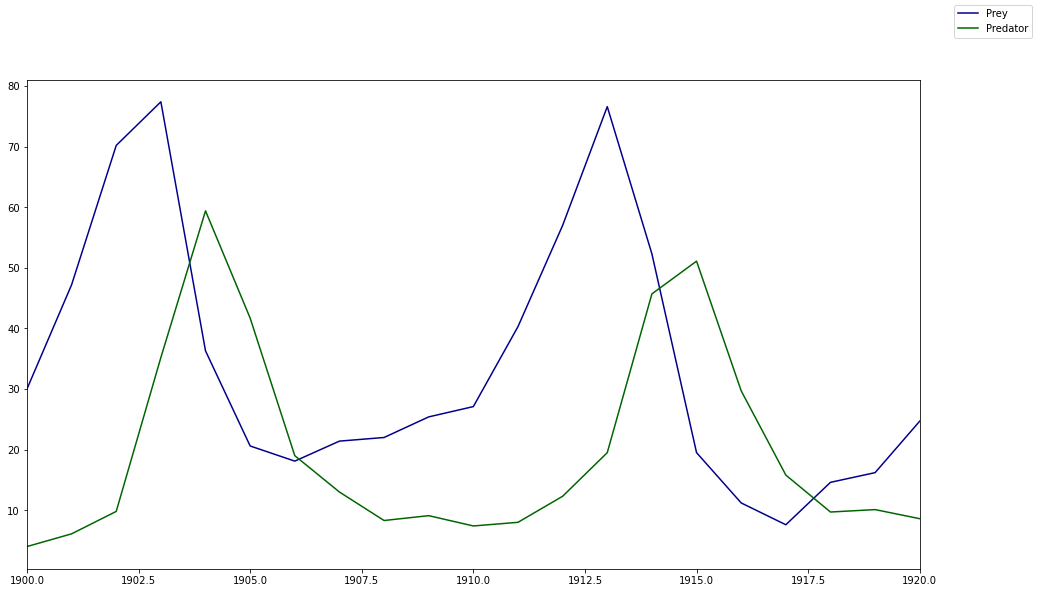

In [1]:
import matplotlib.pyplot as plt
import numpy as np

lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])

data = np.hstack((hare[:, None], lynx[:, None]))

fig, ax = plt.subplots(figsize=(16, 9))

years = np.arange(1900, 1921, 1)

hare_color = "darkblue"
lynx_color = "darkgreen"

ax.plot(years, hare, color=hare_color, label="Prey")
ax.plot(years, lynx, color=lynx_color, label="Predator")

ax.set_xlim(years[0], years[-1])

fig.legend()

The model is given by the following differential equation

\begin{cases}
\frac{dx}{dt} = \alpha x_t - \beta x_t y_t, \\
\frac{dy}{dt} = -\gamma y_t + \delta x_t y_t.
\end{cases}

An issue with this model is that `pyfilter` is designed for state-space models, therefore we need to recast the model into state-space form by introducing an artifical noise process as in TODO, as well as adding an observational equation. We also use RK4 for approximating the ODE. We end up with the following model definition

\begin{cases}
X_{t+\Delta t} = g_x(X_t, Y_t, \theta, \Delta t) + \tau W^x_t, \\
Y_{t+\Delta t} = g_y(X_t, Y_t, \theta, \Delta t) + \tau W^y_t,
\end{cases}

where we let $g_j$ denote the RK4 method applied the RHS of the first equations, $\theta$ denote the parameter set, $W^j_t \sim \mathcal{N}(0, \Delta t)$, and $\tau$ a tuning parameter. We assume, somewhat erronously, that the observations model is given by

\begin{cases}
Z^x_t = X_t + V^x_t, \\
Z^y_t = Y_t + V^y_t, \\
t \in \mathbb{N}.
\end{cases}

Where $V^i_t \sim \mathcal{N}(0, \sigma)$.

Expressing this model using `pyfilter` gives

In [2]:
from pyfilter.timeseries import RungeKutta, LinearGaussianObservations
from pyfilter.utils import concater
from pyfilter.distributions import Prior
from torch.distributions import Exponential, Normal, Independent, LogNormal
import torch


def f(x, alpha, beta, gamma, delta):
    xt, yt = x.values[..., 0], x.values[..., 1]

    cross_prod = xt * yt
    f_x = xt * alpha - beta * cross_prod
    f_y = -yt * gamma + delta * cross_prod
    
    return concater(f_x, f_y)


y = torch.from_numpy(data).float()
dt = 0.25
num_steps = 4

alpha = Prior(Exponential, rate=1.0)
beta = Prior(Exponential, rate=5.0)
gamma = Prior(Exponential, rate=1.0)
delta = Prior(Exponential, rate=5.0)

initial_values = Prior(lambda **u: Independent(Normal(**u), 1), loc=y[0], scale=torch.ones(2))
lotka_volterra = RungeKutta(f, (alpha, beta, gamma, delta), initial_values, dt=dt, tuning_std=1e-1, num_steps=num_steps)

model = LinearGaussianObservations(lotka_volterra, torch.eye(2), [0.25])

Now, we'll perform the inference part. To that end we'll use the `VariationalBayes` algorithm.

In [3]:
from pyfilter.inference.batch.variational import VariationalBayes, approximation as apx

param_approx = apx.ParameterMeanField()
state_approx = apx.StateMeanField()

alg = VariationalBayes(
    model,
    parameter_approximation=param_approx,
    n_samples=12, 
    max_iter=200_000, 
    opt_kwargs={"lr": 1e-2},
    state_approximation=state_approx,
)

res = alg.fit(y)

VariationalBayes - Loss: 4,020.82:  29%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                      | 57774/200000 [07:54<19:28, 121.72it/s]


We start by visualizing the inferred states

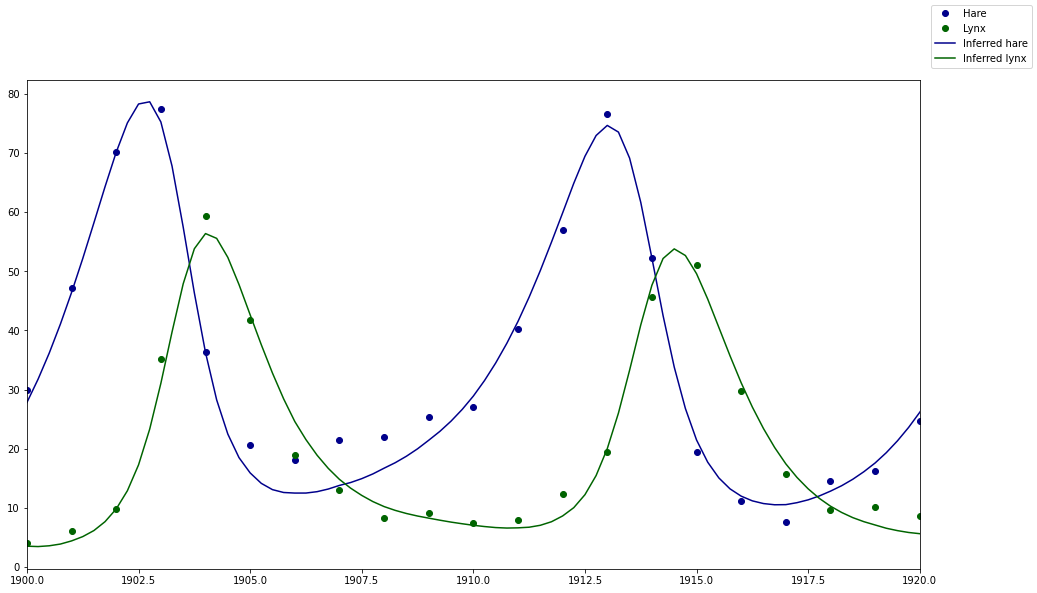

In [4]:
fig, ax = plt.subplots(figsize=(16, 9))

expanded_years = np.arange(1900, 1921, dt)

ax.plot(years, hare, "o", color=hare_color, label="Hare")
ax.plot(years, lynx, "o", color=lynx_color, label="Lynx")

inferred_states = state_approx.get_inferred_states().detach().numpy()[1:]

ax.plot(expanded_years, inferred_states[:, 0], color=hare_color, label="Inferred hare")
ax.plot(expanded_years, inferred_states[:, 1], color=lynx_color, label="Inferred lynx")

ax.set_xlim(years[0], years[-1])

fig.legend()

Next, let's plot the distributions.

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'hare_0'}>,
        <AxesSubplot:title={'center':'lynx_0'}>]], dtype=object)

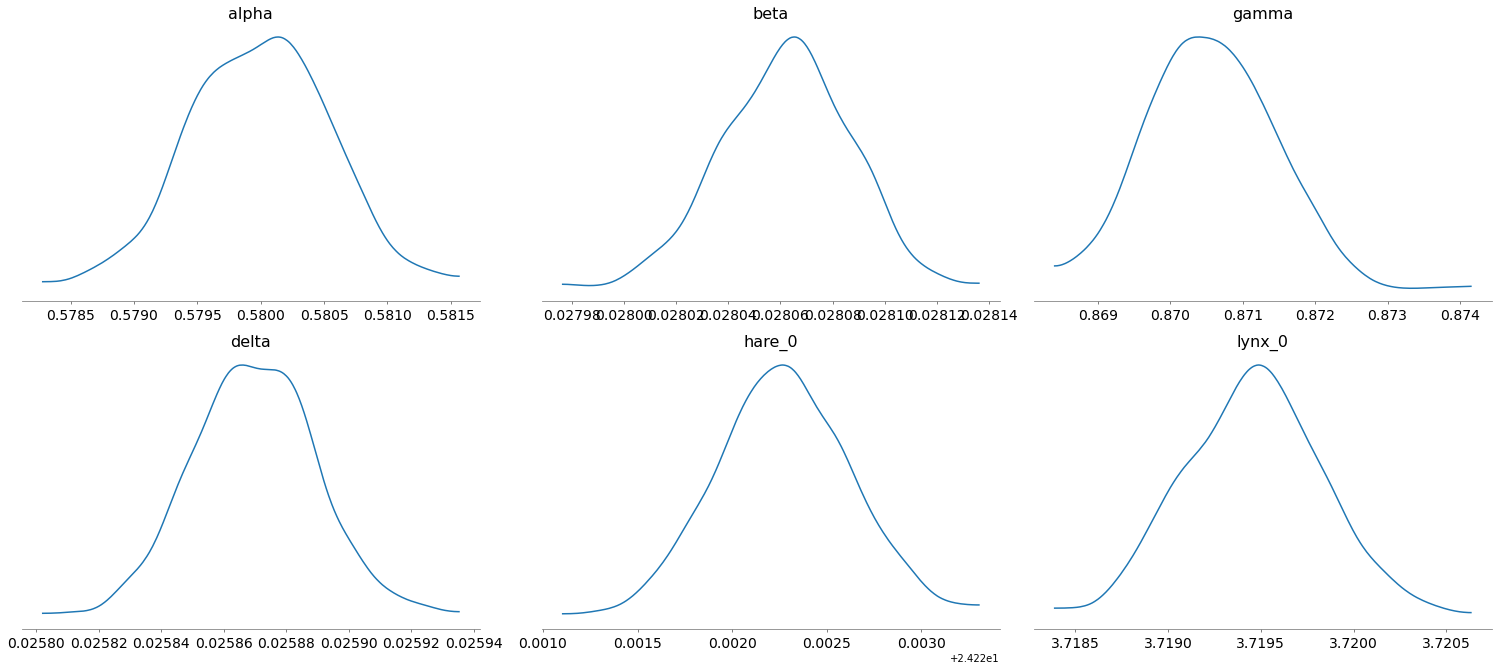

In [5]:
from arviz import plot_posterior, convert_to_inference_data
import pandas as pd

monte_carlo_samples = (1_000,)


var_names = [
    "alpha",
    "beta",
    "gamma",
    "delta",
    "hare_0",
    "lynx_0",
    "sigma"
]

samples = torch.cat(
    tuple(d.sample(monte_carlo_samples) for d in param_approx.get_transformed_dists()), 
    axis=1
).t()

data = {
    vn: s.numpy() 
    for vn, s in zip(var_names, samples)
}

plot_posterior(data, hdi_prob="hide", point_estimate=None)